## Import Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
clrs=["#006400","#00FA9A"]
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import os
import plotly.express as px
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score,confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.metrics import AUC, BinaryAccuracy, Precision, Recall
from glob import glob
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D,BatchNormalization,MaxPool2D,Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import PIL
import imageio
from scipy.signal import convolve2d
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

## Importing and analysing Data

In [ ]:
prec=[]
rcl=[]
f1=[]
acc=[]
train_path="D:/Datasets/Covid_Chest_Data_XRAY/Covid_Chest/Covid19-dataset/train"
test_path="D:/Datasets/Covid_Chest_Data_XRAY/Covid_Chest/Covid19-dataset/test"
train_dir = pathlib.Path("D:/Datasets/Covid_Chest_Data_XRAY/Covid_Chest/Covid19-dataset/train")
test_dir = pathlib.Path("D:/Datasets/Covid_Chest_Data_XRAY/Covid_Chest/Covid19-dataset/test")
labels=os.listdir(test_dir)
print(labels)

['Covid', 'Normal', 'Viral Pneumonia']


### Image Data Splitting

In [ ]:
train_count = len(list(train_dir.glob('*/*.*')))
test_count = len(list(test_dir.glob('*/*.*')))

print(" ======================================")
print("  Images in Training set : {} \n  Images in Test det : {}".format(train_count,test_count))
print(" ======================================")
cats=["Train","Test"]
vals=[train_count, test_count]
valdf=pd.DataFrame({"Directories":cats,"Count":vals})
fig=px.pie(valdf,names="Directories",values="Count",color="Directories",
           title="Images in Train and Test Directories",height=600,width=600)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(
    font=dict(
        family="Times New Roman, Bold",
        size=20,
        color="Black"
    )
)
fig.show()

  Images in Training set : 251 
  Images in Test det : 66


In [ ]:
trn=os.listdir(train_dir)
tst=os.listdir(test_dir)
trdata=[]
tsdata=[]
types=['Covid', 'Normal', 'Viral Pneumonia']
for i in trn:
    trdata.append(len(os.listdir(os.path.join(train_dir,i))))
for i in tst:
    tsdata.append(len(os.listdir(os.path.join(test_dir,i))))
xrayimages=pd.DataFrame({"Category":types,"Train":trdata,"Test":tsdata})
for i in range(len(xrayimages)):
    print("======================================================")
    print("  Available training images in {} is {}".format(xrayimages['Category'][i],xrayimages['Train'][i]))
    print("  Available test images in {} is {}".format(xrayimages['Category'][i],xrayimages['Test'][i]))
print("======================================================")

  Available training images in Covid is 111
  Available test images in Covid is 26
  Available training images in Normal is 70
  Available test images in Normal is 20
  Available training images in Viral Pneumonia is 70
  Available test images in Viral Pneumonia is 20


In [ ]:
fig=px.pie(xrayimages,names="Category",values="Train",color="Category",title="Number of Images Train Set",height=600,width=600)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(
    font=dict(
        family="Times New Roman, Bold",
        size=20,
        color="purple"
    )
)
fig.show()

In [ ]:
fig=px.pie(xrayimages,names="Category",values="Test",color="Category",title="Number of Images Test Set",height=600,width=600)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(
    font=dict(
        family="Times New Roman, Bold",
        size=20,
        color="purple"
    )
)
fig.show()

In [ ]:
covid_train = list(train_dir.glob("Covid/*"))
pnemonia_train = list(train_dir.glob("Viral Pneumonia/*"))
normal_train = list(train_dir.glob("Normal/*"))

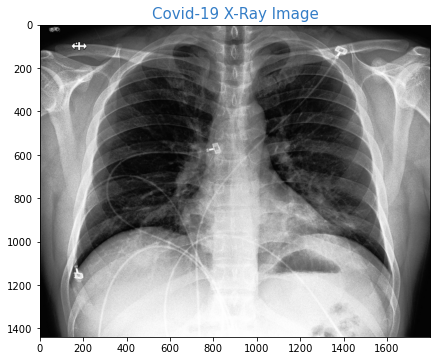

In [ ]:
covid_img = PIL.Image.open(covid_train[20])
plt.figure(figsize=(7,7))
plt.title("Covid-19 X-Ray Image",fontsize=15,color="#357EC7")
plt.imshow(covid_img)

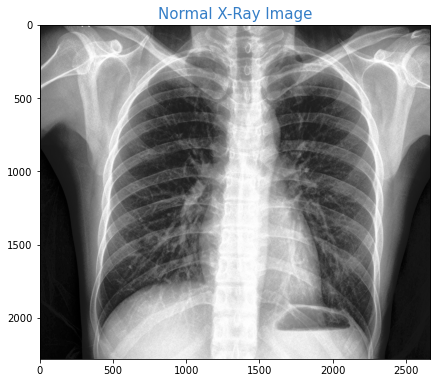

In [ ]:
normal_img = PIL.Image.open(normal_train[20])
plt.figure(figsize=(7,7))
plt.title("Normal X-Ray Image",fontsize=15,color="#357EC7")
plt.imshow(normal_img)

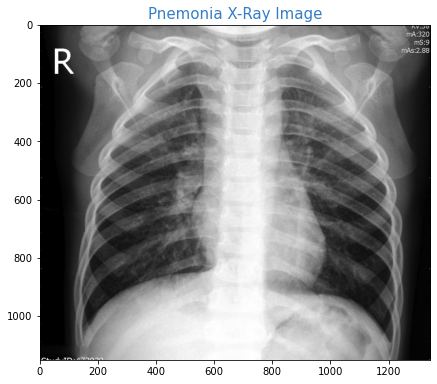

In [ ]:
pnemonia_img = PIL.Image.open(pnemonia_train[12])
plt.figure(figsize=(7,7))
plt.title("Pnemonia X-Ray Image",fontsize=15,color="#357EC7")
plt.imshow(pnemonia_img)

## Load in tensorflow and preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
batch_size = 16
img_h = 128
img_w = 128

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(img_h, img_w),
  batch_size=batch_size)
train_generator = train_datagen.flow_from_directory(
        train_path,
        classes=labels,
        target_size=(img_h, img_w),
        batch_size=32,
        class_mode='categorical')

Found 251 files belonging to 3 classes.
Found 251 images belonging to 3 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    image_size =(img_h,img_w),
    batch_size = batch_size)
test_generator = test_datagen.flow_from_directory(
        test_path,
        classes=labels,
        target_size=(img_h,img_w),
        batch_size=32,
        class_mode='categorical')

Found 66 files belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Viral Pneumonia']


## Visualizing the dataset

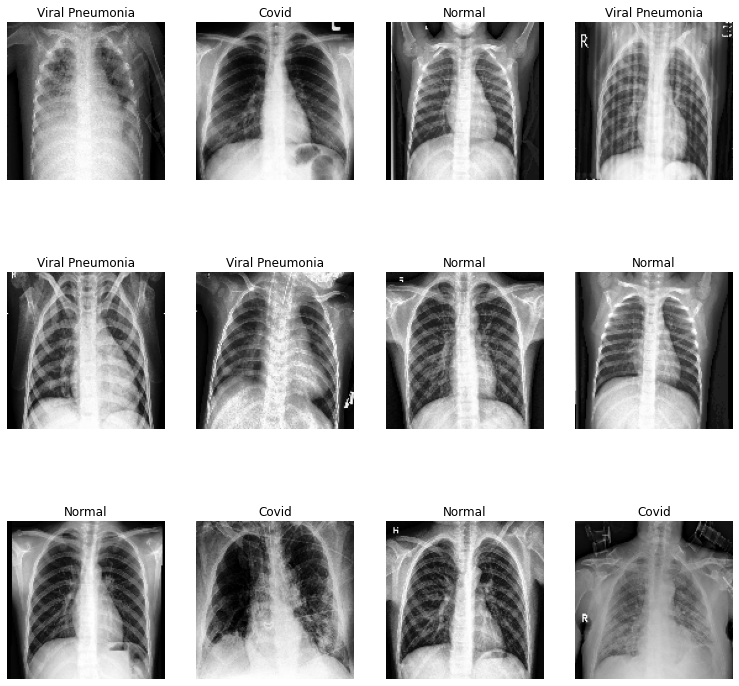

In [ ]:
totplot=12
plt.figure(figsize=(13, 13))
for images, labels in train_ds.take(1):
    for i in range(totplot):
        ax = plt.subplot(int(totplot/4), int(totplot/3), i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 128, 128, 3)
(16,)


In [ ]:
normalizing_layer = layers.experimental.preprocessing.Rescaling(1./255)

## Keras Sequencial Model for CNN

In [ ]:
cnnmodel = Sequential([
    normalizing_layer,
    layers.Conv2D(16,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation = "relu"),
    layers.Dense(3),
    layers.Activation('softmax')
])

In [ ]:
cnnmodel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])   #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
epochs=30
history_cnn = cnnmodel.fit(
  train_generator,
  batch_size=16,
  validation_data=test_generator,
  epochs=epochs)

Epoch 1/30
8/8 [==============================] - 35s 4s/step - loss: 1.0944 - accuracy: 0.3944 - val_loss: 1.0908 - val_accuracy: 0.3939
Epoch 2/30
8/8 [==============================] - 23s 3s/step - loss: 1.0740 - accuracy: 0.4422 - val_loss: 1.1013 - val_accuracy: 0.3939
Epoch 3/30
8/8 [==============================] - 20s 2s/step - loss: 1.0746 - accuracy: 0.4422 - val_loss: 1.0789 - val_accuracy: 0.3939
Epoch 4/30
8/8 [==============================] - 20s 3s/step - loss: 1.0655 - accuracy: 0.4422 - val_loss: 1.0650 - val_accuracy: 0.3939
Epoch 5/30
8/8 [==============================] - 20s 2s/step - loss: 1.0470 - accuracy: 0.4422 - val_loss: 1.0518 - val_accuracy: 0.3939
Epoch 6/30
8/8 [==============================] - 21s 3s/step - loss: 1.0224 - accuracy: 0.4502 - val_loss: 0.9732 - val_accuracy: 0.5152
Epoch 7/30
8/8 [==============================] - 20s 2s/step - loss: 0.9666 - accuracy: 0.5378 - val_loss: 0.8943 - val_accuracy: 0.6818
Epoch 8/30
8/8 [==================

In [ ]:
cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, None, None, None)  0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

In [ ]:
cnnepch_result=history_cnn.history
cnn_res_df=pd.DataFrame({
    "Epoch":[i+1 for i in range(30)],
    "Training Loss":cnnepch_result['loss'],
    "Test Loss":cnnepch_result['val_loss'],
    "Training Accuracy":cnnepch_result['accuracy'],
    "Test Accuracy":cnnepch_result['val_accuracy']
})
cnn_res_df.to_csv("model_cnn.csv")
cnn_res_df

Epoch  Training Loss  Test Loss  Training Accuracy  Test Accuracy
0       1       1.094352   1.090762           0.394422       0.393939
1       2       1.074049   1.101263           0.442231       0.393939
2       3       1.074551   1.078853           0.442231       0.393939
3       4       1.065508   1.064951           0.442231       0.393939
4       5       1.046985   1.051751           0.442231       0.393939
5       6       1.022426   0.973225           0.450199       0.515152
6       7       0.966649   0.894291           0.537849       0.681818
7       8       0.908425   0.796694           0.609562       0.621212
8       9       0.816474   0.765628           0.637450       0.621212
9      10       0.771952   0.771050           0.661355       0.590909
10     11       0.726951   0.647754           0.653386       0.666667
11     12       0.694425   0.649559           0.685259       0.651515
12     13       0.724598   0.692373           0.685259       0.621212
13     14       0.662181   0.625003           0.701195       0.666667
14     15       0.727008   0.638446           0.689243       0.681818
15     16       0.730579   0.711595           0.673307       0.636364
16     17       0.660888   0.579949           0.741036       0.742424
17     18       0.729449   0.708347           0.657371       0.651515
18     19       0.723946   0.671229           0.673307       0.636364
19     20       0.620300   0.724419           0.749004       0.651515
20     21       0.729703   0.689891           0.645418       0.636364
21     22       0.629332   0.645600           0.741036       0.666667
22     23       0.718483   0.851482           0.665339       0.575758
23     24       0.639761   0.619882           0.725100       0.681818
24     25       0.669730   0.655022           0.681275       0.696970
25     26       0.548968   0.602012           0.796813       0.727273
26     27       0.686546   0.706477           0.713147       0.621212
27     28       0.669612   0.664157           0.701195       0.696970
28     29       0.643583   0.588102           0.737052       0.742424
29     30       0.697854   0.679528           0.673307       0.712121

In [ ]:
def vizperform(df,sidx,eidx,typechart,typ):
    df.iloc[:,sidx:eidx].plot(kind=typechart,figsize=(10,5),color=clrs)
    plt.title("Comparison of {}".format(typ),fontsize=20,color=clrs[0])
    plt.xlabel("Epoch",fontsize=17,color=clrs[0])
    plt.ylabel("Model {}".format(typ),fontsize=17,color=clrs[0])
    plt.grid()
    plt.show()

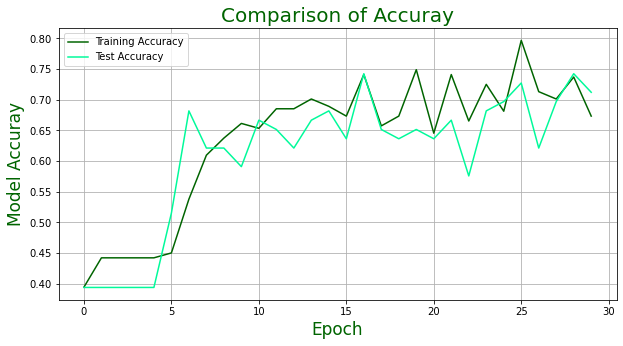

In [ ]:
vizperform(cnn_res_df,3,5,"line","Accuray")

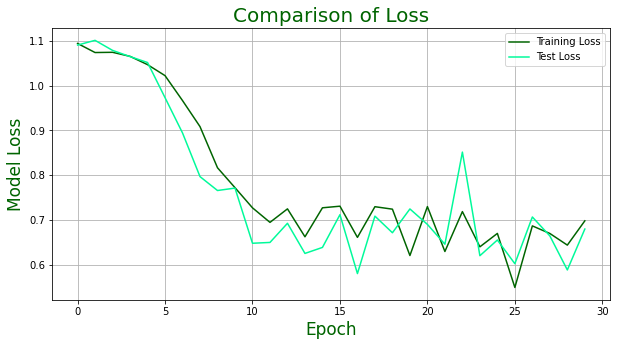

In [ ]:
vizperform(cnn_res_df,1,3,"line","Loss")

In [ ]:
cnnprd = cnnmodel.predict(train_generator)   
cnnprd = np.argmax(cnnprd, axis=1)
class_labels = train_generator.classes
dfcnn_cm=pd.DataFrame({"Actual":class_labels,"Predicted":cnnprd})
dfcnn_cm["Actual"]=dfcnn_cm["Actual"].replace(dfcnn_cm["Actual"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
dfcnn_cm["Predicted"]=dfcnn_cm["Predicted"].replace(dfcnn_cm["Predicted"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
prec.append(round(precision_score(dfcnn_cm["Actual"], dfcnn_cm["Predicted"], average='micro'),2)*100)     
rcl.append(round(recall_score(dfcnn_cm["Actual"], dfcnn_cm["Predicted"], average='micro'),2)*100)
f1.append(round(f1_score(dfcnn_cm["Actual"], dfcnn_cm["Predicted"], average='micro'),2)*100)
acc.append(round(cnn_res_df['Training Accuracy'].max(),4)*100)
print("Accuracy for CNN Model => {}%".format(round(cnn_res_df['Training Accuracy'].max(),4)*100))
ct_cnn=pd.crosstab(dfcnn_cm["Actual"], dfcnn_cm["Predicted"], rownames=['True'], colnames=['Predicted'], margins=True)
ct_cnn.iloc[:3,:3]

Accuracy for CNN Model => 79.67999999999999%


Predicted        Covid  Normal  Viral Pneumonia
True                                           
Covid               24      43               44
Normal              19      28               23
Viral Pneumonia     19      27               24

['Covid', 'Normal', 'Viral Pneumonia']


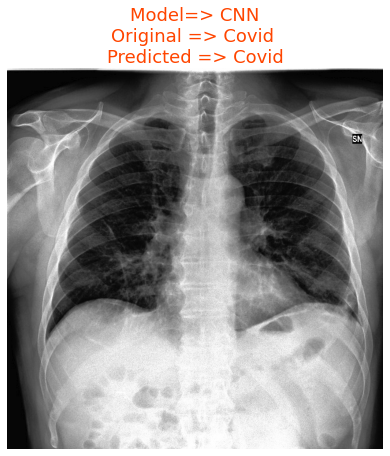

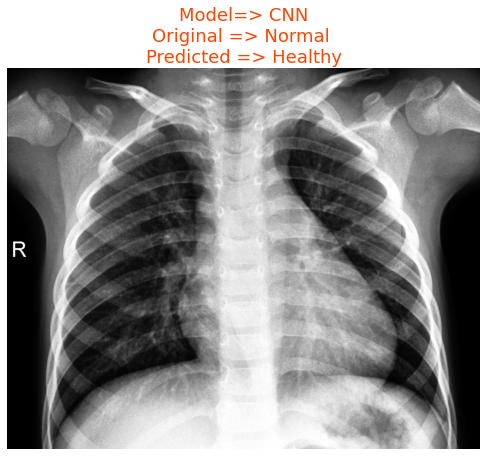

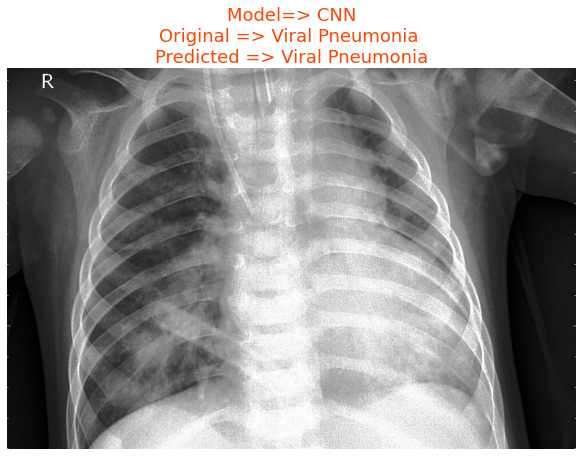

In [ ]:
def plotfig(pres,dr,pr):
    plt.figure(figsize=(14,7))
    picpred=imageio.imread(pres)
    plt.title("\nOriginal => {} \nPredicted => {}".format(mdl,dr,pr),fontsize=18,color="#FF4500")
    plt.imshow(picpred)
    plt.axis('off')
    plt.show()
def predchest(pres,dr,mdl):
    im = mpimg.imread(pres)
    img = image.load_img(pres,target_size=(img_h,img_w))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    pred=mdl.predict(img)
    pred_1=np.argmax(pred, axis=1)
    if pred_1[0]==0:
        plotfig(pres,dr,"Covid")
    elif pred_1[0]==1:
        plotfig(pres,dr,"Healthy")
    elif pred_1[0]==2:
        plotfig(pres,dr,"Viral Pneumonia")
    
lbldir=os.listdir(test_path)
print(lbldir)
pres=os.path.join(test_path,lbldir[0],os.listdir(test_path+"/"+lbldir[0])[0])
predchest(pres,lbldir[0],cnnmodel)
pres=os.path.join(test_path,lbldir[1],os.listdir(test_path+"/"+lbldir[1])[10])
predchest(pres,lbldir[0],cnnmodel)
pres=os.path.join(test_path,lbldir[2],os.listdir(test_path+"/"+lbldir[2])[9])
predchest(pres,lbldir[0],cnnmodel)

In [ ]:
cnnmodel.save('cnnmodel.h5')

## VGG Model for CNN

In [ ]:
vgg = VGG19(input_shape=[img_h,img_w] + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable=False
imgdrs=glob('D:/Datasets/Covid_Chest_Data_XRAY/Covid_Chest/Covid19-dataset/train/*')
x=Flatten()(vgg.output)
prediction=Dense(len(imgdrs),activation='softmax')(x)
vggmodel = Model(inputs=vgg.input, outputs=prediction)
vggmodel.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
vggmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
history_vgg = vggmodel.fit(
  train_generator,
  batch_size=16,
  validation_data=test_generator,
  epochs=30
)

Epoch 1/30
8/8 [==============================] - 76s 9s/step - loss: 1.0204 - accuracy: 0.5179 - val_loss: 0.7776 - val_accuracy: 0.6061
Epoch 2/30
8/8 [==============================] - 82s 10s/step - loss: 0.6596 - accuracy: 0.7371 - val_loss: 0.4781 - val_accuracy: 0.8182
Epoch 3/30
8/8 [==============================] - 75s 9s/step - loss: 0.5223 - accuracy: 0.8048 - val_loss: 0.4037 - val_accuracy: 0.8182
Epoch 4/30
8/8 [==============================] - 68s 8s/step - loss: 0.4803 - accuracy: 0.8127 - val_loss: 0.3674 - val_accuracy: 0.8182
Epoch 5/30
8/8 [==============================] - 59s 7s/step - loss: 0.4067 - accuracy: 0.8486 - val_loss: 0.3227 - val_accuracy: 0.9091
Epoch 6/30
8/8 [==============================] - 55s 7s/step - loss: 0.3620 - accuracy: 0.8526 - val_loss: 0.3084 - val_accuracy: 0.8485
Epoch 7/30
8/8 [==============================] - 62s 8s/step - loss: 0.3295 - accuracy: 0.8845 - val_loss: 0.2584 - val_accuracy: 0.9394
Epoch 8/30
8/8 [=================

In [ ]:
vggepch_result=history_vgg.history
vgg_res_df=pd.DataFrame({
    "Epoch":[i+1 for i in range(30)],
    "Training Loss":vggepch_result['loss'],
    "Test Loss":vggepch_result['val_loss'],
    "Training Accuracy":vggepch_result['accuracy'],
    "Test Accuracy":vggepch_result['val_accuracy']
})
vgg_res_df.to_csv("model_vgg.csv")
vgg_res_df

Epoch  Training Loss  Test Loss  Training Accuracy  Test Accuracy
0       1       1.020379   0.777612           0.517928       0.606061
1       2       0.659607   0.478142           0.737052       0.818182
2       3       0.522316   0.403725           0.804781       0.818182
3       4       0.480307   0.367416           0.812749       0.818182
4       5       0.406681   0.322710           0.848606       0.909091
5       6       0.362036   0.308428           0.852590       0.848485
6       7       0.329512   0.258409           0.884462       0.939394
7       8       0.333947   0.290022           0.876494       0.878788
8       9       0.298640   0.244271           0.900398       0.909091
9      10       0.301187   0.235762           0.908367       0.924242
10     11       0.301485   0.205389           0.896414       0.939394
11     12       0.311446   0.369295           0.880478       0.848485
12     13       0.283238   0.175074           0.888446       0.924242
13     14       0.267088   0.297010           0.908367       0.848485
14     15       0.266262   0.193808           0.900398       0.909091
15     16       0.237380   0.164007           0.900398       0.969697
16     17       0.250060   0.196305           0.912351       0.924242
17     18       0.274882   0.152417           0.900398       0.954545
18     19       0.209313   0.194786           0.936255       0.909091
19     20       0.248617   0.158152           0.916335       0.939394
20     21       0.245677   0.200516           0.908367       0.909091
21     22       0.211595   0.167469           0.920319       0.924242
22     23       0.224015   0.160648           0.924303       0.954545
23     24       0.216517   0.142944           0.932271       0.939394
24     25       0.218440   0.151853           0.920319       0.939394
25     26       0.223340   0.133828           0.928287       0.954545
26     27       0.204147   0.186051           0.924303       0.909091
27     28       0.182138   0.145219           0.936255       0.939394
28     29       0.175818   0.198891           0.936255       0.909091
29     30       0.198056   0.141079           0.912351       0.939394

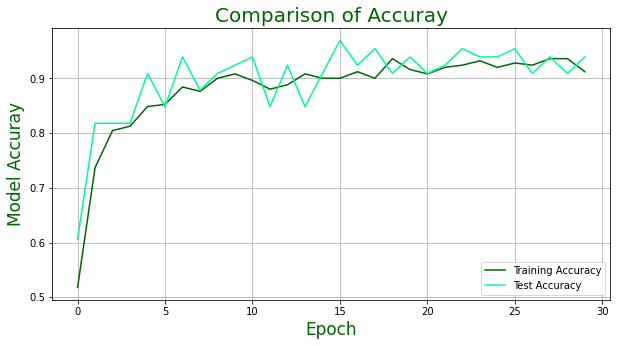

In [ ]:
vizperform(vgg_res_df,3,5,"line","Accuray")

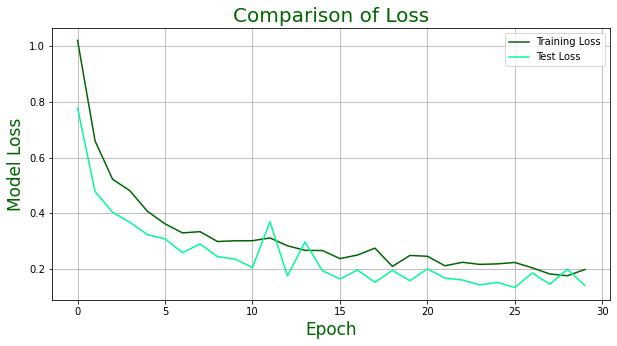

In [ ]:
vizperform(vgg_res_df,1,3,"line","Loss")

In [ ]:
vggprd = vggmodel.predict(train_generator)
vggprd = np.argmax(vggprd, axis=1)
class_labels = train_generator.classes
dfvgg_cm=pd.DataFrame({"Actual":class_labels,"Predicted":vggprd})
dfvgg_cm["Actual"]=dfvgg_cm["Actual"].replace(dfvgg_cm["Actual"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
dfvgg_cm["Predicted"]=dfvgg_cm["Predicted"].replace(dfvgg_cm["Predicted"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
prec.append(round(precision_score(dfvgg_cm["Actual"], dfvgg_cm["Predicted"], average='micro'),2)*100)     # Precision of the model
rcl.append(round(recall_score(dfvgg_cm["Actual"], dfvgg_cm["Predicted"], average='micro'),2)*100)     # Recall of the model
f1.append(round(f1_score(dfvgg_cm["Actual"], dfvgg_cm["Predicted"], average='micro'),2)*100)     # F1-Score of the model
acc.append(round(vgg_res_df['Training Accuracy'].max(),4)*100)
print("Accuracy for VGG16 Model => {}".format(round(vgg_res_df['Training Accuracy'].max(),4)*100))
ct_vgg=pd.crosstab(dfvgg_cm["Actual"], dfvgg_cm["Predicted"], rownames=['True'], colnames=['Predicted'], margins=True)
ct_vgg.iloc[:3,:3]

Accuracy for VGG16 Model => 93.63


Predicted        Covid  Normal  Viral Pneumonia
True                                           
Covid               29      28               54
Normal              23      23               24
Viral Pneumonia     24      15               31

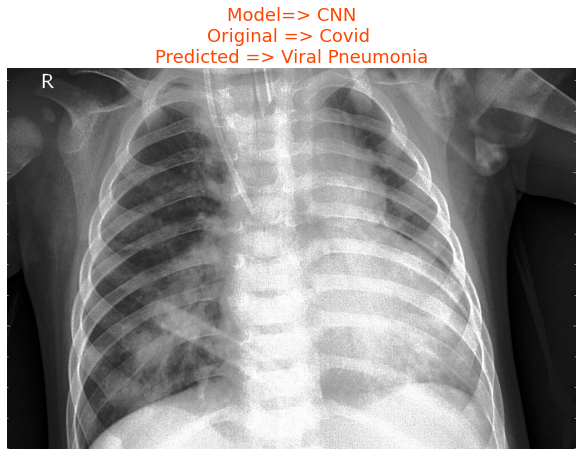

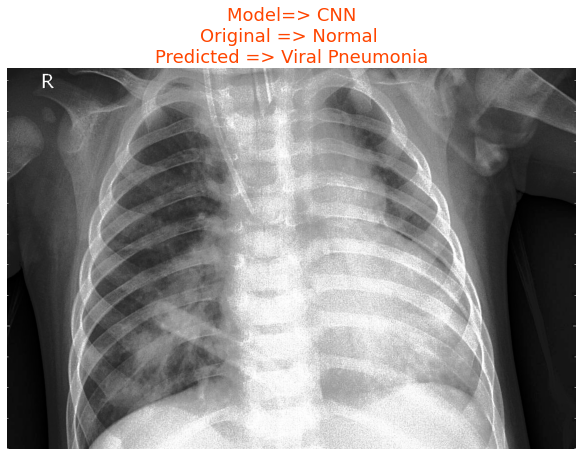

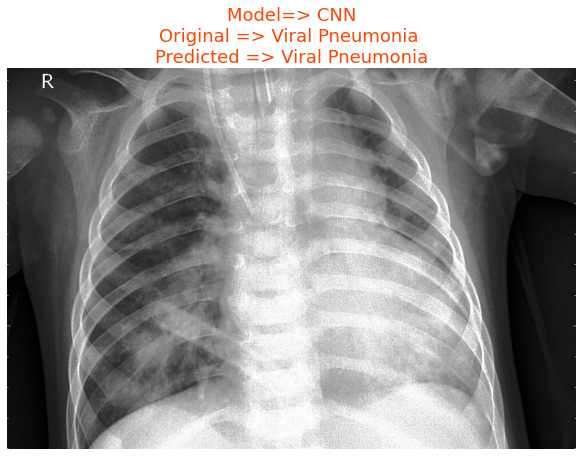

In [ ]:
predchest(pres,lbldir[0],vggmodel)
predchest(pres,lbldir[1],vggmodel)
predchest(pres,lbldir[2],vggmodel)

In [ ]:
vggmodel.save('vggmodel.h5')

## DenseNet121 Model for CNN

In [ ]:
trainset=[]
mapping={ 'Normal':0,'Viral Pneumonia':1,'Covid':2 }

In [ ]:
den121 = tf.keras.applications.DenseNet201(input_shape=(img_h,img_w,3),include_top=False,weights='imagenet',pooling='avg')
den121.trainable = False

inputs_den =den121.input
lydn = tf.keras.layers.Dense(128, activation='relu')(den121.output)
denout = tf.keras.layers.Dense(3, activation='softmax')(lydn)
denmodel = tf.keras.Model(inputs=inputs_den, outputs=denout)

denmodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history_den = denmodel.fit(
  train_generator,
  batch_size=16,
  validation_data=test_generator,
  epochs=30
)

Epoch 1/30
8/8 [==============================] - 57s 5s/step - loss: 0.8821 - accuracy: 0.6295 - val_loss: 0.4844 - val_accuracy: 0.8333
Epoch 2/30
8/8 [==============================] - 39s 5s/step - loss: 0.4641 - accuracy: 0.8088 - val_loss: 0.6989 - val_accuracy: 0.6818
Epoch 3/30
8/8 [==============================] - 38s 5s/step - loss: 0.3314 - accuracy: 0.8765 - val_loss: 0.7160 - val_accuracy: 0.7424
Epoch 4/30
8/8 [==============================] - 39s 5s/step - loss: 0.3086 - accuracy: 0.8566 - val_loss: 0.5720 - val_accuracy: 0.7879
Epoch 5/30
8/8 [==============================] - 36s 5s/step - loss: 0.2734 - accuracy: 0.8845 - val_loss: 0.4140 - val_accuracy: 0.8182
Epoch 6/30
8/8 [==============================] - 37s 5s/step - loss: 0.2513 - accuracy: 0.9044 - val_loss: 0.4891 - val_accuracy: 0.8485
Epoch 7/30
8/8 [==============================] - 35s 4s/step - loss: 0.2449 - accuracy: 0.9124 - val_loss: 0.4380 - val_accuracy: 0.8333
Epoch 8/30
8/8 [==================

In [ ]:
denmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

conv4_block25_0_bn (BatchNormal (None, 8, 8, 1024)   4096        conv4_block24_concat[0][0]       
__________________________________________________________________________________________________
conv4_block25_0_relu (Activatio (None, 8, 8, 1024)   0           conv4_block25_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block25_1_conv (Conv2D)   (None, 8, 8, 128)    131072      conv4_block25_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block25_1_bn (BatchNormal (None, 8, 8, 128)    512         conv4_block25_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block25_1_relu (Activatio (None, 8, 8, 128)    0           conv4_block25_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc

conv4_block36_1_bn (BatchNormal (None, 8, 8, 128)    512         conv4_block36_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block36_1_relu (Activatio (None, 8, 8, 128)    0           conv4_block36_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block36_2_conv (Conv2D)   (None, 8, 8, 32)     36864       conv4_block36_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block36_concat (Concatena (None, 8, 8, 1408)   0           conv4_block35_concat[0][0]       
                                                                 conv4_block36_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block37_0_bn (BatchNormal (None, 8, 8, 1408)   5632        conv4_block36_concat[0][0]       
__________

Total params: 18,568,259
Trainable params: 246,275
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [ ]:
denepch_result=history_den.history
den_res_df=pd.DataFrame({
    "Epoch":[i+1 for i in range(30)],
    "Training Loss":denepch_result['loss'],
    "Test Loss":denepch_result['val_loss'],
    "Training Accuracy":denepch_result['accuracy'],
    "Test Accuracy":denepch_result['val_accuracy']
})
den_res_df.to_csv("model_den.csv")
den_res_df

Epoch  Training Loss  Test Loss  Training Accuracy  Test Accuracy
0       1       0.882060   0.484358           0.629482       0.833333
1       2       0.464109   0.698933           0.808765       0.681818
2       3       0.331393   0.716001           0.876494       0.742424
3       4       0.308611   0.572018           0.856574       0.787879
4       5       0.273392   0.414035           0.884462       0.818182
5       6       0.251341   0.489102           0.904382       0.848485
6       7       0.244897   0.437981           0.912351       0.833333
7       8       0.168574   0.351358           0.936255       0.833333
8       9       0.167680   0.330266           0.940239       0.863636
9      10       0.170649   0.325464           0.948207       0.833333
10     11       0.202107   0.381645           0.920319       0.878788
11     12       0.142542   0.337928           0.960159       0.848485
12     13       0.162386   0.469590           0.940239       0.818182
13     14       0.215063   0.378346           0.924303       0.878788
14     15       0.188832   0.605279           0.924303       0.787879
15     16       0.175755   0.363670           0.932271       0.848485
16     17       0.249257   0.455048           0.908367       0.818182
17     18       0.192987   0.372715           0.920319       0.848485
18     19       0.128345   0.267884           0.960159       0.878788
19     20       0.121552   0.295654           0.952191       0.863636
20     21       0.104717   0.385087           0.960159       0.863636
21     22       0.135422   0.307682           0.944223       0.863636
22     23       0.132974   0.324625           0.944223       0.863636
23     24       0.138425   0.472948           0.932271       0.818182
24     25       0.104254   0.317162           0.964143       0.833333
25     26       0.109320   0.347141           0.960159       0.848485
26     27       0.125341   0.298992           0.940239       0.878788
27     28       0.086408   0.269482           0.960159       0.893939
28     29       0.092471   0.330220           0.956175       0.863636
29     30       0.087249   0.392216           0.968127       0.878788

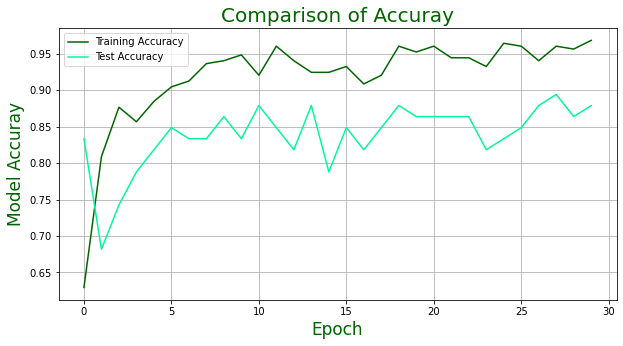

In [ ]:
vizperform(den_res_df,3,5,"line","Accuray")

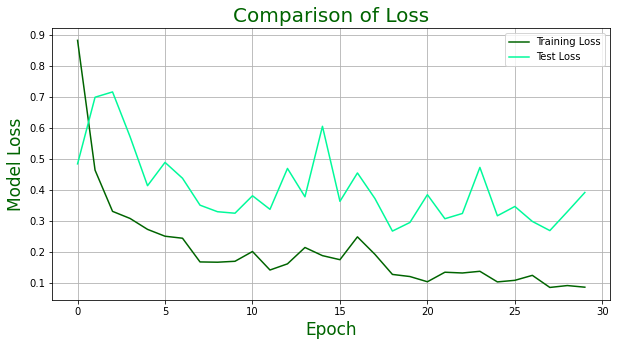

In [ ]:
vizperform(den_res_df,1,3,"line","Loss")

In [ ]:
denprd = denmodel.predict(train_generator)
denprd = np.argmax(denprd, axis=1)
class_labels = train_generator.classes
dfden_cm=pd.DataFrame({"Actual":class_labels,"Predicted":denprd})
dfden_cm["Actual"]=dfden_cm["Actual"].replace(dfden_cm["Actual"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
dfden_cm["Predicted"]=dfden_cm["Predicted"].replace(dfden_cm["Predicted"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
prec.append(round(precision_score(dfden_cm["Actual"], dfden_cm["Predicted"], average='micro'),2)*100)     # Precision of the model
rcl.append(round(recall_score(dfden_cm["Actual"], dfden_cm["Predicted"], average='micro'),2)*100)     # Recall of the model
f1.append(round(f1_score(dfden_cm["Actual"], dfden_cm["Predicted"], average='micro'),2)*100)     # F1-Score of the model
acc.append(round(den_res_df['Training Accuracy'].max(),4)*100)
print("Accuracy for DenseNet121 Model => {}".format(round(den_res_df['Training Accuracy'].max(),4)*100))
ct_den=pd.crosstab(dfden_cm["Actual"], dfden_cm["Predicted"], rownames=['True'], colnames=['Predicted'], margins=True)
ct_den.iloc[:3,:3]

Accuracy for DenseNet121 Model => 96.81


Predicted        Covid  Normal  Viral Pneumonia
True                                           
Covid               42      34               35
Normal              29      21               20
Viral Pneumonia     39      16               15

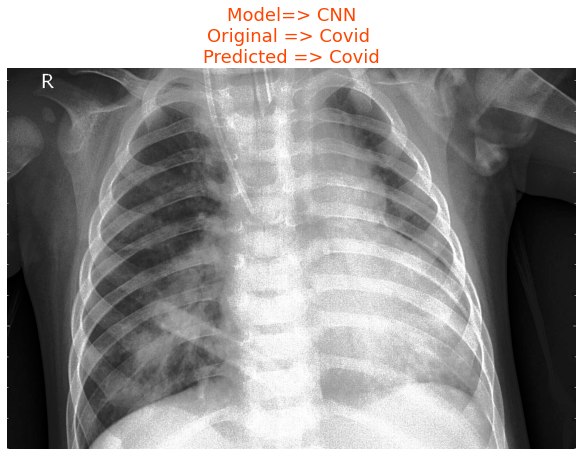

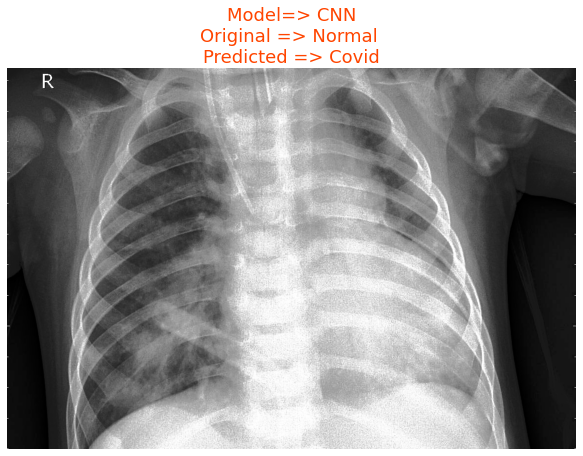

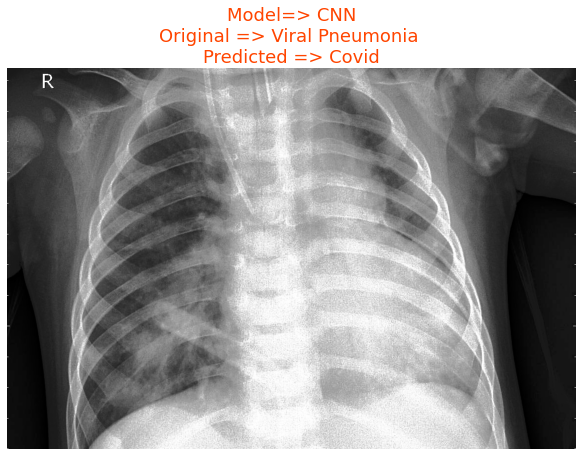

In [ ]:
predchest(pres,lbldir[0],denmodel)
predchest(pres,lbldir[1],denmodel)
predchest(pres,lbldir[2],denmodel)

In [ ]:
denmodel.save('denmodel.h5')

In [ ]:
chect_xray_detect=pd.DataFrame({
    "Algorithm":["CNN","VGG16","DenseNet201"],
    "Accuracy":acc    
})


chect_xray_detect=chect_xray_detect.sort_values(by="Accuracy",ascending=False)
fig = px.bar(chect_xray_detect, y="Accuracy", x="Algorithm",color="Accuracy", text="Accuracy",title="Comparison of Accuracy",height=450,width=600)
fig.update_layout(
    font=dict(
         family="Times New Roman, Bold",
         size=20,
         color="black"
    )
)
fig.show()

In [ ]:
auths=["Dasare & Harsha (2021)","Shah et al. (2022)","Shadeed et al. (2021)",
       "Wang (2022)","Anwar & Zakir (2020)",
       "Horry et al. (2020)","Narın & Onur (2021)","Sakib et al. (2021)","Proposed Model"]
acc=[96.66,96,96.15,95.6,89.7,86,94.44 ,96,96.81]
athdf=pd.DataFrame({"Authors":auths,"Accuracy":acc})
athdf=athdf.sort_values(by="Accuracy",ascending=False)
fig = px.bar(athdf, x="Authors", y="Accuracy",text="Accuracy",color="Accuracy",
                 title="Comparison of Research and Approaches".format(i),height=500,width=700)
fig.update_layout(
    font=dict(
        family="Times New Roman, Bold",
        size=20,
        color="black"
    )
)
fig.show()